# Imports

In [ ]:
import umap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms.v2 as transforms
from torch.amp import GradScaler, autocast
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, SequentialLR
from torch.utils.data import Dataset
from tqdm import tqdm
import plotly.express as px

# Constants

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
IMAGE_SIZE = 32
NUM_CLASSES = 10
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2470, 0.2435, 0.2616)

EMBEDDING_SIZE = 128
TEMPERATURE = 0.01

WARMUP_EPOCHS = 10
PRETRAINING_EPOCHS = 100
PRETRAINIG_SUBSET_EPOCHS = 30
FINETUNING_EPOCHS = 50
SUPERVISED_EPOCHS = PRETRAINING_EPOCHS + FINETUNING_EPOCHS
SUPERVISED_SUBSET_EPOCHS = PRETRAINING_EPOCHS + PRETRAINIG_SUBSET_EPOCHS

BATCH_SIZE = 512
INITIAL_LR = 1e-3
FINAL_LR = 3e-5
WEIGHT_DECAY_FINETUNING = 1e-3
WEIGHT_DECAY_SUPERVISED = 1e-2

SEED = 42

# Data augmentation

In [9]:
cifar10 = torchvision.datasets.CIFAR10(root="../datasets", train=True, download=True)
cifar10[0]

Files already downloaded and verified


(<PIL.Image.Image image mode=RGB size=32x32>, 6)

In [10]:
contrastive_transform = transforms.Compose(
    [
        transforms.ToImage(),
        transforms.ToDtype(dtype=torch.float32, scale=True),
        torchvision.transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(size=IMAGE_SIZE),
        transforms.RandomApply(
            [
                transforms.ColorJitter(
                    brightness=0.8, contrast=0.8, saturation=0.8, hue=0.2
                ),
            ],
            p=0.8,
        ),
        transforms.RandomGrayscale(p=0.2),
        transforms.GaussianBlur(kernel_size=3),
        transforms.Normalize(mean=CIFAR10_MEAN, std=CIFAR10_STD),
    ]
)

In [11]:
def denormalize(x):
    x = x * torch.tensor(CIFAR10_STD).view(3, 1, 1)
    x = x + torch.tensor(CIFAR10_MEAN).view(3, 1, 1)
    return x

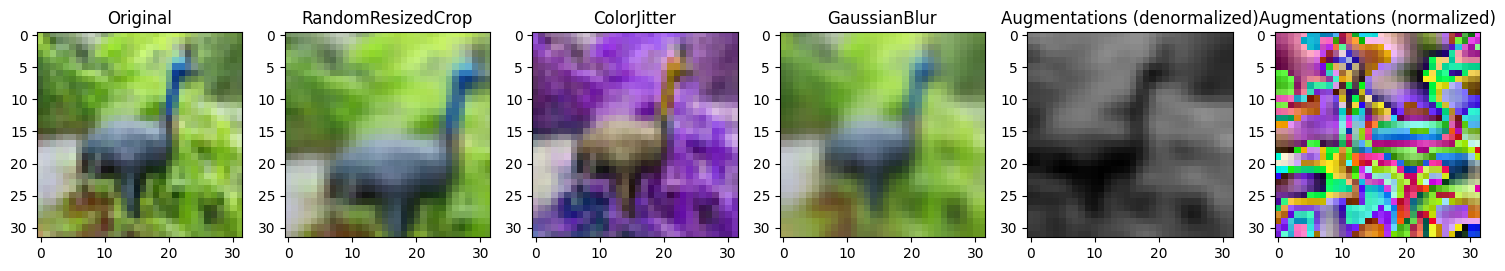

In [12]:
img_pil, label = cifar10[6]
to_tensor = transforms.ToImage()
to_pil = transforms.ToPILImage()

fig, axs = plt.subplots(1, 6, figsize=(15, 5))

axs[0].imshow(img_pil)
axs[0].set_title("Original")

axs[1].imshow(to_pil(transforms.RandomResizedCrop(size=IMAGE_SIZE)(to_tensor(img_pil))))
axs[1].set_title("RandomResizedCrop")

axs[2].imshow(to_pil(transforms.ColorJitter(hue=0.5)(to_tensor(img_pil))))
axs[2].set_title("ColorJitter")

axs[3].imshow(to_pil(transforms.GaussianBlur(kernel_size=3)(to_tensor(img_pil))))
axs[3].set_title("GaussianBlur")

axs[4].imshow(to_pil(denormalize(contrastive_transform(to_tensor(img_pil)))))
axs[4].set_title("Augmentations (denormalized)")

axs[5].imshow(to_pil(contrastive_transform(to_tensor(img_pil))))
axs[5].set_title("Augmentations (normalized)")

plt.tight_layout()
plt.show()

# Contrastive dataset

In [13]:
class ContrastiveDataset(Dataset):
    def __init__(self, dataset, augmentations):
        self.dataset = dataset
        self.augmentations = augmentations

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]
        return self.augmentations(img), self.augmentations(img)

    def __len__(self):
        return len(self.dataset)

# Loss

In [14]:
class NTXent(nn.Module):
    def __init__(self, temperature):
        super().__init__()
        self.temperature = temperature

    def forward(self, z_i, z_j):
        batch_size = z_i.shape[0]
        assert batch_size == z_j.shape[0], "Batch sizes must match"

        z_i = F.normalize(z_i, dim=-1)
        z_j = F.normalize(z_j, dim=-1)

        z = torch.cat([z_i, z_j], dim=0)  # [2 * batch_size, embedding_size]

        similarity_matrix = (
            F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=-1)
            / self.temperature
        )  # [2 * batch_size, 2 * batch_size]

        sim_i_j = torch.diag(similarity_matrix, batch_size)  # [batch_size]
        sim_j_i = torch.diag(similarity_matrix, -batch_size)  # [batch_size]

        positive_samples = torch.cat([sim_i_j, sim_j_i], dim=0).unsqueeze(
            1
        )  # [2 * batch_size, 1]

        # mask = torch.ones(
        #     batch_size * 2, batch_size * 2, dtype=torch.bool
        # ).fill_diagonal_(False)  # [2 * batch_size, 2 * batch_size]

        # for i in range(batch_size):
        #     mask[i, batch_size + i] = False
        #     mask[batch_size + i, i] = False

        mask = torch.zeros(
            2 * batch_size,
            2 * batch_size,
            dtype=torch.bool,
            device=similarity_matrix.device,
        )
        indices = torch.arange(batch_size, device=similarity_matrix.device)
        mask.scatter_(1, indices, True)
        mask.scatter_(0, indices + batch_size, True)

        negative_samples = similarity_matrix[mask].view(
            batch_size * 2, -1
        )  # [2 * batch_size, batch_size - 2]
        logits = torch.cat(
            [positive_samples, negative_samples], dim=-1
        )  # [2 * batch_size, batch_size - 1]
        labels = torch.zeros(batch_size * 2, dtype=torch.long).to(
            logits.device
        )  # [2 * batch_size]
        loss = F.cross_entropy(logits, labels, reduction="sum")
        return loss / (2 * batch_size)

# Encoder Model

In [15]:
class Encoder(nn.Module):
    def __init__(self, encoder: nn.Module, projection_size: int):
        super().__init__()

        assert hasattr(encoder, "fc"), "Base encoder must have a fc layer"

        self.encoder = encoder
        self.embedding_size = self.encoder.fc.in_features
        self.encoder.fc = nn.Identity()
        self.projection_head = nn.Sequential(
            nn.Linear(self.embedding_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, projection_size),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.projection_head(x)
        return x

# Data Split

In [16]:
train_dataset, valid_dataset = torch.utils.data.random_split(
    torchvision.datasets.CIFAR10(root="../datasets", train=True, download=True),
    [45000, 5000],
    generator=torch.Generator().manual_seed(SEED),
)
test_dataset = torchvision.datasets.CIFAR10(
    root="../datasets", train=False, download=True
)

Files already downloaded and verified
Files already downloaded and verified


In [17]:
eval_transforms = transforms.Compose(
    [
        transforms.ToImage(),
        transforms.ToDtype(dtype=torch.float32, scale=True),
        transforms.Normalize(mean=CIFAR10_MEAN, std=CIFAR10_STD),
    ]
)

# Self-Supervised Pretraining

In [18]:
train_contrastive_dataset = ContrastiveDataset(train_dataset, contrastive_transform)
valid_contrastive_dataset = ContrastiveDataset(valid_dataset, eval_transforms)
test_contrastive_dataset = ContrastiveDataset(test_dataset, eval_transforms)

train_loader = torch.utils.data.DataLoader(
    train_contrastive_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)
val_loader = torch.utils.data.DataLoader(
    valid_contrastive_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)
test_loader = torch.utils.data.DataLoader(
    test_contrastive_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)

In [19]:
encoder = Encoder(
    encoder=torchvision.models.resnet18(weights=None),
    projection_size=EMBEDDING_SIZE,
).to(device)
optimizer = torch.optim.AdamW(encoder.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = NTXent(temperature=TEMPERATURE).to(device)
scaler = GradScaler(device=device)
scheduler = SequentialLR(
    optimizer,
    schedulers=[
        LinearLR(
            optimizer, start_factor=0.1, end_factor=1.0, total_iters=WARMUP_EPOCHS
        ),
        CosineAnnealingLR(
            optimizer, T_max=PRETRAINING_EPOCHS - WARMUP_EPOCHS, eta_min=FINAL_LR
        ),
    ],
    milestones=[WARMUP_EPOCHS],
)

In [ ]:
train_losses = []
val_losses = []
best_val_loss = float("inf")

for epoch in range(PRETRAINING_EPOCHS):
    encoder.train()
    train_loss = 0.0
    num_batches = 0
    progress_bar = tqdm(
        train_loader, desc=f"Epoch {epoch + 1}/{PRETRAINING_EPOCHS} [Train]"
    )
    for imgs_i, imgs_j in progress_bar:
        imgs_i = imgs_i.to(device, non_blocking=True)
        imgs_j = imgs_j.to(device, non_blocking=True)

        optimizer.zero_grad()

        with autocast(device_type=device.type):
            combined = torch.cat([imgs_i, imgs_j], dim=0)
            embeddings = encoder(combined)
            z_i, z_j = torch.split(embeddings, BATCH_SIZE)
            loss = criterion(z_i, z_j)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        num_batches += 1
        progress_bar.set_postfix({"loss": loss.item()})

    epoch_avg_train_loss = train_loss / num_batches
    train_losses.append(epoch_avg_train_loss)

    encoder.eval()
    val_loss = 0.0
    num_batches = 0
    progress_bar = tqdm(
        val_loader, desc=f"Epoch {epoch + 1}/{PRETRAINING_EPOCHS} [Valid]"
    )
    for imgs_i, imgs_j in progress_bar:
        imgs_i = imgs_i.to(device, non_blocking=True)
        imgs_j = imgs_j.to(device, non_blocking=True)

        with torch.no_grad():
            with autocast(device_type=device.type):
                combined = torch.cat([imgs_i, imgs_j], dim=0)
                embeddings = encoder(combined)
                z_i, z_j = torch.split(embeddings, BATCH_SIZE)
                loss = criterion(z_i, z_j)

        val_loss += loss.item()
        num_batches += 1
        progress_bar.set_postfix({"loss": loss.item()})

    epoch_avg_val_loss = val_loss / num_batches
    val_losses.append(epoch_avg_val_loss)

    if epoch_avg_val_loss < best_val_loss:
        best_val_loss = epoch_avg_val_loss
        torch.save(encoder.state_dict(), "cifar10_encoder_best.pth")
        print(f"Saved new best model with val_loss: {best_val_loss:.4f}")

    scheduler.step()

torch.save(encoder.state_dict(), "cifar10_encoder.pth")

In [20]:
def get_encoder(pretrained: bool):
    encoder = Encoder(
        encoder=torchvision.models.resnet18(weights=None),
        projection_size=EMBEDDING_SIZE,
    ).to(device)
    if pretrained:
        encoder.load_state_dict(
            torch.load(
                "/kaggle/input/simclr/pytorch/default/1/cifar10_encoder.pth",
                weights_only=True,
            )
        )
    encoder.projection_head = nn.Identity()
    return encoder

# Classifier Training Loop

In [21]:
def train_supervised(
    model: nn.Module,
    train_loader: torch.utils.data.DataLoader,
    val_loader: torch.utils.data.DataLoader,
    test_loader: torch.utils.data.DataLoader,
    epochs: int,
    warmup_epochs: int,
    initial_lr: float,
    final_lr: float,
    weight_decay: float,
    experiment_name: str,
    device=device,
):
    optimizer = torch.optim.AdamW(
        model.parameters(), lr=initial_lr, weight_decay=weight_decay
    )
    criterion = nn.CrossEntropyLoss().to(device)
    scaler = GradScaler(device=device)
    scheduler = SequentialLR(
        optimizer,
        schedulers=[
            LinearLR(
                optimizer, start_factor=0.1, end_factor=1.0, total_iters=warmup_epochs
            ),
            CosineAnnealingLR(
                optimizer, T_max=epochs - warmup_epochs, eta_min=final_lr
            ),
        ],
        milestones=[warmup_epochs],
    )

    train_losses = []
    val_losses = []
    best_val_loss = float("inf")

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} [Train]")

        for i, (imgs, labels) in enumerate(progress_bar):
            imgs, labels = (
                imgs.to(device, non_blocking=True),
                labels.to(device, non_blocking=True),
            )

            optimizer.zero_grad()

            with autocast(device_type=device.type):
                logits = model(imgs)
                loss = criterion(logits, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()

            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            progress_bar.set_postfix(
                {"loss": loss.item(), "acc": 100 * correct / total}
            )

        epoch_train_acc = 100 * correct / total
        epoch_avg_train_loss = train_loss / (i + 1)
        train_losses.append(epoch_avg_train_loss)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{epochs} [Valid]")

        with torch.no_grad():
            for i, (imgs, labels) in enumerate(progress_bar):
                imgs, labels = (
                    imgs.to(device, non_blocking=True),
                    labels.to(device, non_blocking=True),
                )

                with autocast(device_type=device.type):
                    logits = model(imgs)
                    loss = criterion(logits, labels)

                val_loss += loss.item()

                _, predicted = torch.max(logits.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                progress_bar.set_postfix(
                    {"loss": loss.item(), "acc": 100 * correct / total}
                )

        epoch_val_acc = 100 * correct / total
        epoch_avg_val_loss = val_loss / (i + 1)
        val_losses.append(epoch_avg_val_loss)

        if epoch_avg_val_loss < best_val_loss:
            best_val_loss = epoch_avg_val_loss
            torch.save(model.state_dict(), f"cifar10_{experiment_name}.pth")

        scheduler.step()

        print(
            f"Epoch {epoch + 1}/{epochs}, Train Loss: {epoch_avg_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%, "
            f"Val Loss: {epoch_avg_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%, LR: {scheduler.get_last_lr()[0]:.6f}"
        )

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100 * correct / total
    print(f"Test Accuracy ({experiment_name}): {test_acc:.2f}%")

    return train_losses, val_losses, test_acc

In [22]:
class Classifier(nn.Module):
    def __init__(self, encoder: Encoder, num_classes):
        super().__init__()
        self.encoder = encoder
        self.classifier = torch.nn.Sequential(
            nn.Linear(self.encoder.embedding_size, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        with torch.no_grad():
            x = self.encoder(x)
        x = self.classifier(x)
        return x

In [23]:
def create_classifier(pretrained: bool, freeze_encoder: bool):
    classifier = Classifier(
        encoder=get_encoder(pretrained=pretrained), num_classes=10
    ).to(device)

    if freeze_encoder:
        for param in classifier.encoder.parameters():
            param.requires_grad = False

    return classifier

# Data Preparation

In [24]:
class TransformedDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        return self.transform(img), label

    def __len__(self):
        return len(self.dataset)

In [25]:
train_transforms = transforms.Compose(
    [
        transforms.ToImage(),
        transforms.ToDtype(dtype=torch.float32, scale=True),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(size=IMAGE_SIZE, scale=(0.8, 1.0)),
        transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
    ]
)

train_transformed = TransformedDataset(train_dataset, train_transforms)
valid_transformed = TransformedDataset(valid_dataset, eval_transforms)
test_transformed = TransformedDataset(test_dataset, eval_transforms)

train_loader = torch.utils.data.DataLoader(
    train_transformed,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)
val_loader = torch.utils.data.DataLoader(
    valid_transformed,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)
test_loader = torch.utils.data.DataLoader(
    test_transformed,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)

# Self-Supervised Learning + Fine-Tuning

In [ ]:
classifier_finetuned = create_classifier(pretrained=True, freeze_encoder=True)

finetuned_train_losses, finetuned_val_losses, finetuned_test_acc = train_supervised(
    classifier_finetuned,
    train_loader,
    val_loader,
    test_loader,
    epochs=FINETUNING_EPOCHS,
    warmup_epochs=WARMUP_EPOCHS,
    initial_lr=INITIAL_LR,
    final_lr=FINAL_LR,
    weight_decay=WEIGHT_DECAY_FINETUNING,
    experiment_name="finetuned",
    device=device,
)

# Supervised Learninig Baseline

In [ ]:
supervised_model = create_classifier(pretrained=False, freeze_encoder=False)

supervised_train_losses, supervised_val_losses, supervised_test_acc = train_supervised(
    supervised_model,
    train_loader,
    val_loader,
    test_loader,
    epochs=SUPERVISED_EPOCHS,
    warmup_epochs=WARMUP_EPOCHS,
    initial_lr=INITIAL_LR,
    final_lr=FINAL_LR,
    weight_decay=WEIGHT_DECAY_SUPERVISED,
    experiment_name="supervised",
    device=device,
)

# Training on 10% of CIFAR10

In [26]:
def create_subset(dataset, fraction=0.1):
    total_size = len(dataset)
    subset_size = int(total_size * fraction)

    indices = torch.randperm(total_size, generator=torch.Generator().manual_seed(SEED))
    subset_indices = indices[:subset_size]

    return torch.utils.data.Subset(dataset, subset_indices)


train_subset = create_subset(train_transformed, fraction=0.1)
print(
    f"Full training set size: {len(train_transformed)}, 10% subset size: {len(train_subset)}"
)

subset_train_loader = torch.utils.data.DataLoader(
    train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)

Full training set size: 45000, 10% subset size: 4500


## Finetuning on 10% CIFAR10

In [ ]:
classifier_finetuned_10pct = create_classifier(pretrained=True, freeze_encoder=True)

finetuned_10pct_train_losses, finetuned_10pct_val_losses, finetuned_10pct_test_acc = (
    train_supervised(
        classifier_finetuned_10pct,
        subset_train_loader,
        val_loader,
        test_loader,
        epochs=PRETRAINIG_SUBSET_EPOCHS,
        warmup_epochs=WARMUP_EPOCHS,
        initial_lr=INITIAL_LR,
        final_lr=FINAL_LR,
        experiment_name="finetuned_10pct",
        device=device,
    )
)

## Supervised training on 10% CIFAR10

In [ ]:
classifier_supervised_10pct = create_classifier(pretrained=False, freeze_encoder=False)

(
    supervised_10pct_train_losses,
    supervised_10pct_val_losses,
    supervised_10pct_test_acc,
) = train_supervised(
    classifier_supervised_10pct,
    subset_train_loader,
    val_loader,
    test_loader,
    warmup_epochs=WARMUP_EPOCHS,
    epochs=SUPERVISED_SUBSET_EPOCHS,
    initial_lr=INITIAL_LR,
    final_lr=FINAL_LR,
    weight_decay=WEIGHT_DECAY_SUPERVISED,
    experiment_name="supervised_10pct",
    device=device,
)

# Results Comparison

In [ ]:
sns.set_theme(style="whitegrid")
plt.rcParams.update({"font.size": 12})

plt.figure(figsize=(12, 6))
methods = ["SimCLR + 100%", "Supervised 100%", "SimCLR + 10%", "Supervised 10%"]
accuracies = [
    finetuned_test_acc,
    supervised_test_acc,
    finetuned_10pct_test_acc,
    supervised_10pct_test_acc,
]

accuracy_df = pd.DataFrame(
    {
        "Method": methods,
        "Accuracy": accuracies,
        "Color": ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"],
    }
)

ax = sns.barplot(
    x="Method", y="Accuracy", data=accuracy_df, palette=accuracy_df["Color"]
)
ax.set_title("Test Accuracy Comparison", fontsize=16)
ax.set_ylabel("Accuracy (%)", fontsize=14)
ax.set_ylim(0, 100)

for i, bar in enumerate(ax.patches):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,
        f"{accuracies[i]:.1f}%",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

plt.tight_layout()
plt.savefig("accuracy_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

plt.figure(figsize=(16, 7))

epochs = range(1, len(supervised_train_losses) + 1)
data = []

for values, name in [
    (supervised_train_losses, "Supervised (100%)"),
    (finetuned_train_losses, "SimCLR + 100% finetune"),
    (supervised_10pct_train_losses, "Supervised (10%)"),
    (finetuned_10pct_train_losses, "SimCLR + 10% finetune"),
]:
    for epoch, value in zip(epochs, values):
        data.append({"Epoch": epoch, "Loss": value, "Method": name, "Type": "Training"})

for values, name in [
    (supervised_val_losses, "Supervised (100%)"),
    (finetuned_val_losses, "SimCLR + 100% finetune"),
    (supervised_10pct_val_losses, "Supervised (10%)"),
    (finetuned_10pct_val_losses, "SimCLR + 10% finetune"),
]:
    for epoch, value in zip(epochs, values):
        data.append(
            {"Epoch": epoch, "Loss": value, "Method": name, "Type": "Validation"}
        )

losses_df = pd.DataFrame(data)

plt.subplot(1, 2, 1)
sns.lineplot(
    data=losses_df[losses_df["Type"] == "Training"],
    x="Epoch",
    y="Loss",
    hue="Method",
    palette="tab10",
    linewidth=2.5,
    markers=True,
    dashes=False,
)
plt.title("Training Loss Comparison", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(title=None, fontsize=12)

plt.subplot(1, 2, 2)
sns.lineplot(
    data=losses_df[losses_df["Type"] == "Validation"],
    x="Epoch",
    y="Loss",
    hue="Method",
    palette="tab10",
    linewidth=2.5,
    markers=True,
    dashes=False,
)
plt.title("Validation Loss Comparison", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(title=None, fontsize=12)

plt.tight_layout()
plt.savefig("loss_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

# Summary

In [ ]:
results = {
    "Method": [
        "SimCLR + 100% (frozen)",
        "Supervised 100% (longer training)",
        "SimCLR + 10% (frozen)",
        "Supervised 10% (longer training)",
    ],
    "Test Accuracy": [
        finetuned_test_acc,
        supervised_test_acc,
        finetuned_10pct_test_acc,
        supervised_10pct_test_acc,
    ],
    "Training Epochs": [
        f"{PRETRAINING_EPOCHS} + {FINETUNING_EPOCHS}",
        f"{SUPERVISED_EPOCHS}",
        f"{PRETRAINING_EPOCHS} + {PRETRAINIG_SUBSET_EPOCHS}",
        f"{SUPERVISED_SUBSET_EPOCHS}",
    ],
    "Frozen Encoder": ["Yes", "No", "Yes", "No"],
    "Trainable Parameters": [
        format(
            sum(
                p.numel() for p in classifier_finetuned.parameters() if p.requires_grad
            ),
            ",",
        ),
        format(
            sum(p.numel() for p in supervised_model.parameters() if p.requires_grad),
            ",",
        ),
        format(
            sum(
                p.numel()
                for p in classifier_finetuned_10pct.parameters()
                if p.requires_grad
            ),
            ",",
        ),
        format(
            sum(
                p.numel()
                for p in classifier_supervised_10pct.parameters()
                if p.requires_grad
            ),
            ",",
        ),
    ],
}

results_df = pd.DataFrame(results)
results_df

# Embeddings Visualization

In [57]:
def extract_embeddings(model, data_loader, num_samples=1000):
    model.eval()
    embeddings = []
    labels = []
    count = 0

    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Extracting embeddings"):
            images = images.to(device)
            batch_embeddings = model.encoder(images).cpu().numpy()
            batch_labels = targets.numpy()

            embeddings.append(batch_embeddings)
            labels.append(batch_labels)

            count += len(images)
            if count >= num_samples:
                break

    embeddings = np.vstack(embeddings)[:num_samples]
    labels = np.concatenate(labels)[:num_samples]

    return embeddings, labels

In [58]:
pretrained_model = create_classifier(pretrained=True, freeze_encoder=True)

num_samples = 5000
embeddings, labels = extract_embeddings(
    pretrained_model, test_loader, num_samples=num_samples
)

print(f"Embeddings shape: {embeddings.shape}")
print(f"Labels shape: {labels.shape}")

Extracting embeddings:  45%|████▌     | 9/20 [00:00<00:01, 10.88it/s]

Embeddings shape: (5000, 512)
Labels shape: (5000,)


In [ ]:
umap_obj = umap.UMAP(
    n_components=3,
    n_neighbors=30,
    min_dist=0.1,
)
embeddings_reduced = umap_obj.fit_transform(embeddings)

In [ ]:
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

df = pd.DataFrame(
    {
        "x": embeddings_reduced[:, 0],
        "y": embeddings_reduced[:, 1],
        "z": embeddings_reduced[:, 2],
        "label": [class_names[label] for label in labels],
    }
)

fig = px.scatter_3d(
    df,
    x="x",
    y="y",
    z="z",
    color="label",
    title="3D Visualization of Embeddings",
    labels={"label": "Class"},
    color_discrete_sequence=px.colors.qualitative.Plotly,
    opacity=0.8,
)

fig.update_layout(
    scene=dict(
        xaxis=dict(showticklabels=False),
        yaxis=dict(showticklabels=False),
        zaxis=dict(showticklabels=False),
    ),
    legend=dict(itemsizing="constant"),
    margin=dict(r=0, l=0, b=0, t=40),
    height=500,
    width=600,
)
fig.show()